#**Machine Learning in Python - Project 2**

**Gregoris Georgiou, Antonis Hadjiosif, Yasmin Hengster & Eshan Ratnaweera**

## 0. Setup

In [ ]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#from IPython.display import Image                # displaying .png images
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import MinMaxScaler # scaling features
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
import warnings # prevent warnings
warnings.filterwarnings("ignore")
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.metrics import classification_report_imbalanced
import re

from sklearn.model_selection import cross_validate




import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/projects/2')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hotel.csv


In [ ]:
d = pd.read_csv("hotel.csv")

In [ ]:
d = d.drop_duplicates() #are duplicates really duplicates or coincidences for example two families going on holiday together, therefore the same row twice. We have to decide how we interpret that 

# Check to see missing values
#drop company as most of the entries was NaN (maybe want to do the same with agent- maybe cause we also have a lot of agents and I cant see how)
d = d.drop(['company','agent'], axis = 1)
#drop rows where at least one value is NaN 
d = d.dropna()


In [ ]:
d["lead_weeks"] = np.round(d["lead_time"]/7)
d = d.drop('lead_time', axis = 1)

In [ ]:
#modify some of the features
#save day of the month as extra data frame
d_day = pd.DataFrame()
d_day['arrival_date_day_of_month'] = d['arrival_date_day_of_month']

#create column if reserved room is assigned room
d['room_type'] = d['assigned_room_type'] == d['reserved_room_type']
d = d.astype({'room_type': 'int32'})
d = d.drop(['assigned_room_type','reserved_room_type'], axis = 1)

#summarise number of children and babies in 1 feature (because why not)
d['total_children'] = d['children'] + d['babies']
d = d.drop(['babies','children'], axis = 1)

#also drop year (we can't go back in time). Month and day would be interesting (to check if there is a time when it's more likely that people cancel), but can also be summarised in the week number
#Including the days would be useful as an indicator if people might cancel towards the end of the month because there is no money left
#-> definetly drop months (that is included in the week number) 
#looking at the histogram of arrival date day, histogram looks uniformly distributed, therefore arrival day is likely not to influence cancellation
d = d.drop(['arrival_date_month', 'arrival_date_year', 'arrival_date_day_of_month'],axis = 1)


d['stay_in_nights'] = d['stays_in_week_nights'] + d['stays_in_weekend_nights']
d = d.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis = 1)

# when we want to run the model to predict if booking will be canceled, we don't know the number of requests (requests can only be made if booking is not cancelled)
# d = d.drop(['total_of_special_requests'],axis = 1)


In [ ]:
#one-hot encoding

drop_decision = True
dummy_hotel = pd.get_dummies(d['hotel'],
                             drop_first = drop_decision)

dummy_meal = pd.get_dummies(d['meal'],
                            drop_first = drop_decision,
                            prefix = "meal")
#Also make as one column SC and Undefined as in the instructions it means the same thing
dummy_meal['meal_SC'] = dummy_meal['meal_SC'] + dummy_meal['meal_Undefined']
dummy_meal = dummy_meal.drop(['meal_Undefined'], axis = 1)


dummy_country = pd.get_dummies(d['country'],
                               drop_first = drop_decision)


dummy_market_segment = pd.get_dummies(d['market_segment'],
                                      drop_first = drop_decision,
                                      prefix = "market_segment")


dummy_distribution_channel = pd.get_dummies(d['distribution_channel'],
                                            drop_first = drop_decision,
                                            prefix = "distribution_channel")

dummy_deposit_type = pd.get_dummies(d['deposit_type'],
                                       drop_first = drop_decision)

dummy_customer_type = pd.get_dummies(d['customer_type'],
                                       drop_first = drop_decision,
                                     prefix = "customer_type")

d_final = d.drop(['hotel', 'meal', 'country', 'market_segment', 
                  'distribution_channel','deposit_type',
                  'customer_type'], axis = 1)
d_final = pd.concat([d_final, dummy_hotel, dummy_meal, dummy_country,
                     dummy_market_segment, dummy_distribution_channel,
                     dummy_deposit_type, dummy_customer_type], axis=1)


## **1. Introduction**
The purpose of this project is to construct a predictive model that is both accurate and reliable in understanding what aspects of a hotel booking, made by different customers, affect the likelihood of cancelations. The aim of the model is to be as accurate as possible whilst making sure that any incorrect predictions of no cancelations were minimised, as this would mean empty rooms and the hotel would lose money. Thus, we aim for a model that will lead to slightly overbooked hotels. 

We use data collected by [Antonio, Almeida and Nunes, 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191#f0010) that come from the booking systems of two real hotels and reflect bookings made between July 1st, 2015 through August 31st 2017. More speicifically, our data set contains 119,390 observations of 31 variables. After an initial refinement on the data we end up with a dataset of 21 features which can be seen below:

|variable                       |description |
|:------------------------------|:-----------|
|is_canceled                    | Value indicating if the booking was canceled (1) or not (0) |
|hotel                          | Hotel (`Resort Hotel` or `City Hotel`) |
|lead_weeks                      | Number of weeks that elapsed between the entering date of the booking into the PMS and the arrival date |
|arrival_date_week_number       | Week number of year for arrival date|
|stays_nights        | Number of nights in a week the guest stayed or booked to stay at the hotel |
|adults                         | Number of adults|
|total_children                       | Number of children & Number of babies|
|meal                           | Type of meal booked. Categories are presented in standard hospitality meal packages: <br> `Undefined`/`SC` – no meal package;<br>`BB` – Bed & Breakfast; <br> `HB` – Half board (breakfast and one other meal – usually dinner); <br> `FB` – Full board (breakfast, lunch and dinner) |
|country                        | Country of origin. Categories are represented in the ISO 3155–3:2013 format |
|market_segment                 | Market segment designation. In categories, the term `TA` means “Travel Agents” and `TO` means “Tour Operators” |
|distribution_channel           | Booking distribution channel. The term `TA` means “Travel Agents” and `TO` means “Tour Operators” |
|is_repeated_guest              | Value indicating if the booking name was from a repeated guest (`1`) or not (`0`) |
|previous_cancellations         | Number of previous bookings that were cancelled by the customer prior to the current booking |
|previous_bookings_not_canceled | Number of previous bookings not cancelled by the customer prior to the current booking |
|room_type             | Value indicating if the reserved room is the same as the assigned |
|booking_changes                | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|deposit_type                   | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:<br>`No Deposit` – no deposit was made;<br>`Non Refund` – a deposit was made in the value of the total stay cost;<br>`Refundable` – a deposit was made with a value under the total cost of stay. |
|days_in_waiting_list           | Number of days the booking was in the waiting list before it was confirmed to the customer |
|customer_type                  | Type of booking, assuming one of four categories:<br>`Contract` - when the booking has an allotment or other type of contract associated to it;<br>`Group` – when the booking is associated to a group;<br>`Transient` – when the booking is not part of a group or contract, and is not associated to other transient booking;<br>`Transient-party` – when the booking is transient, but is associated to at least other transient booking|
|adr                            | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
|required_car_parking_spaces    | Number of car parking spaces required by the customer |



### **Executive Summary**

We use a logistic regression model to predict the bookings' cancelations. This is done by performing an initial refinement on our dataset and using only variables thought to influence the number of cancelations. After calculating some metrics for our model we conclude that we have an **accurate model of $75\%$** with a **$53\%$ reliability** (precision: the proportion of truly predicting a cancelation compared to the sum of the overall prediction of cancelations). Our main focus though, was to be able to correctly predict a cancelation compared to the bookings which are actually canceled and we achieved that to a proportion close to **$78\%$ (recall)**. 

We predicted features that are either positively or negatively associated with the number of cancelations. Features which influence the number of cancelations (i.e when a booking includes one of these features it is more likely to be canceled - from most to least likely) can be seen below:
* **Room type**
* **Country: Portugal**
* **Lead weeks** - as the weeks from the booking date increase it is more likely to observe a cancelation
* **Previous cancelations** - the greater the number of previous cancelations a client has, the more likely it is to cancel again in the future
* **Customer type: Transient**
* **Market segment: Online Travel Agent**
* **Average Daily Rate** - when the rate is higher a cancelation is more likely

On the other side, features of a booking that make it unlikely to be canceled when observed (following a similar order as before) include:

* **Required car-parking spaces**
* **Total of special requests** - as the special requests increase the less likely it is for a booking to be canceled
* **Previous bookings not canceled** - the amount of previous bookings not canceled indicates a lower chance of future cancelation
* **Market segment: Offline Travel Agent/Tour operator**
* **Repeated Guest**
* **Countries: Great Britain, Germany, France**
* **Booking Changes** - more changes lead to a higher cancelation chance

We aim to build an economically viable model that has more benefits over costs. We do this by focusing on what we find to be the most important aspect in our predictor through our performance analysis. 

## **2. Exploratory Data Analysis and Feature Engineering**

###**2.1 Pre-processing**

Initially, the dataset was checked for duplicates and missing values. It contained $32,252$ duplicates which were checked to figure out if these duplicates were associated with group bookings and thus, would make sense to leave them in our dataset. Of these $32,252$ duplicates only $30$ were associated with group bookings. We concluded that duplicates are associated to errors to the way the system processes the bookings. Therefore we dropped them to prevent overfitting and to have a more accurate final model for the predictions. The dataset had missing values for the following features:
* `Children` - $4$ NAs
* `Country` - $451$ NAs
* `Agent` - $12,160$ NAs
* `Company` - $81,890$ NAs \\

We can see that the features `Agent` and `Company` had missing values that would result in our dataset reducing to $90\%$ and $31\%$ respectively if entries containing these missing values had been removed from it. This would lead to a less accurate model and incorrect predictions. These two features are also consisted of many categories, $333$ and $352$ respectively. Thus, we decided to drop them as it would be hard to draw any conclusions. Finally, we dropped entries containing the rest of the $455$ missing values; resulting in the new dataset being a $99.6\%$ proportion of the initial. We also dropped the features `arrival_date_year`, because time is not a feature we can influence, and `arrival_date_month` because the information in this feature can also be seen in `arrival_date_week_number`. 

We also combined and modified certain variables as we thought this will make the analysis more comprehensive. These variables are seen below:
* `Lead_weeks` = `Lead_time`/7
* `Room` = Reserved room == Assigned room (checks if reserved room agrees with assigned room)`
* `Total_Children` = `Children` + `Babies`
* `Stays_in_Nights` = `Stays_in_week_nights` + `Stays_in_weekend_nights` 






###**2.2 Descriptive statistics**
We summarised descriptive statistics using histograms to remove any features or observations without a predictive behaviour on bookings' cancelations and also, observed a correlation heatmap for the features.



####**2.2.1 Histograms**
As we observe the histograms, we conclude that the feature `arrival_date_day_of_month` is uniformly distributed and so won't have a predictive behaviour on number of cancelations. Thus, it is dropped from our dataset. Moreover, we spotted something very interesting about the feature `required_car_parking_spaces`. The vast majority of the bookings that required at least one car parking space did not canceled their bookings. This fact should not be ommited since there are over 7000 such cases. Thus, we can predict that this feature will play a crucial role, and will be very significant when used in our model.

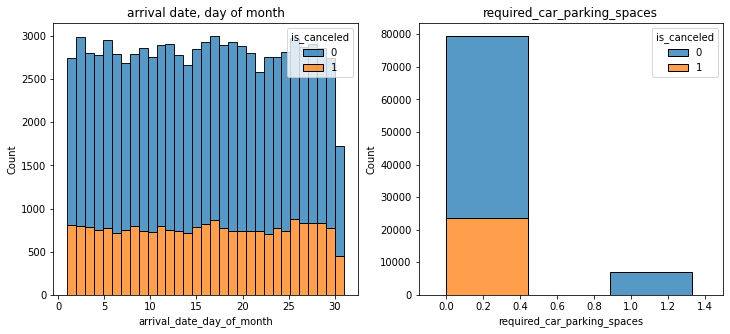

In [ ]:
#@title Histograms
fig, axes = plt.subplots(1, 2, figsize = (12,5))
sns.histplot(ax = axes[0], x = d_day['arrival_date_day_of_month'],hue = d['is_canceled'], multiple="stack",bins=31)
axes[0].set_title('arrival date, day of month')

sns.histplot(ax = axes[1], x = d['required_car_parking_spaces'],hue = d['is_canceled'], multiple="stack")
axes[1].set_xlim(-0.15,1.5)
axes[1].set_title('required_car_parking_spaces')
plt.show()

####**2.2.2 Correlation**
Another reason we combined some and dropped some other of the previously mentioned features was to avoid having highly correlated features. As we can see on the correlation heatmap, the correlation is kept very low with the highest value being 0.43 for `is_repeated_guest` & `previous_bookings_not_canceled` but this value only indicates moderate correlation.

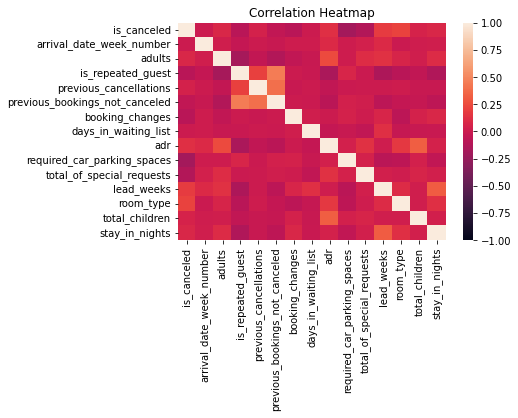

In [ ]:
#@title Correlation
# correlation heatmap of numerical variables
sns.heatmap(df.corr(), vmin = -1, vmax = 1, annot=False)#, fmt='.2f', linewidths=2)
plt.title("Correlation Heatmap")
plt.show()

###**2.3 Processing**

The categorical features `hotel`, `meal`, `country`, `market_segment`, `distribution channel`,`deposit_type` and `customer type` needed special treatment to be used in our modelling. We utilised one-hot encoding for this purpose instead of label encoding, since these data are not ordinal. For example, when treating the `country` column, we have created multiple columns, one for each country registered. We also dropped one column of each feature as the outcome of one variable can easily be predicted with the help of the remaining variables. In this way we avoid the problem of multicollinearity, as we will use logistic regression to build our model. Below our final dataframe is shown which contains 210 columns created by the one hot encoding


In [ ]:
#@title One-hot encoding

drop_decision = True
dummy_hotel = pd.get_dummies(d['hotel'],
                             drop_first = drop_decision)

dummy_meal = pd.get_dummies(d['meal'],
                            drop_first = drop_decision,
                            prefix = "meal")
#Also make as one column SC and Undefined as in the instructions it means the same thing
dummy_meal['meal_SC'] = dummy_meal['meal_SC'] + dummy_meal['meal_Undefined']
dummy_meal = dummy_meal.drop(['meal_Undefined'], axis = 1)


dummy_country = pd.get_dummies(d['country'],
                               drop_first = drop_decision)


dummy_market_segment = pd.get_dummies(d['market_segment'],
                                      drop_first = drop_decision,
                                      prefix = "market_segment")


dummy_distribution_channel = pd.get_dummies(d['distribution_channel'],
                                            drop_first = drop_decision,
                                            prefix = "distribution_channel")

dummy_deposit_type = pd.get_dummies(d['deposit_type'],
                                       drop_first = drop_decision)

dummy_customer_type = pd.get_dummies(d['customer_type'],
                                       drop_first = drop_decision,
                                     prefix = "customer_type")

d_final = d.drop(['hotel', 'meal', 'country', 'market_segment', 
                  'distribution_channel','deposit_type',
                  'customer_type'], axis = 1)
d_final = pd.concat([d_final, dummy_hotel, dummy_meal, dummy_country,
                     dummy_market_segment, dummy_distribution_channel,
                     dummy_deposit_type, dummy_customer_type], axis=1)

In [ ]:
d_final.head()

,is_canceled,arrival_date_week_number,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,...,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,Non Refund,Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,27,2,0,0,0,3,0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,27,2,0,0,0,4,0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,27,1,0,0,0,0,0,75.0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,27,1,0,0,0,0,0,75.0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,27,2,0,0,0,0,0,98.0,0,...,1,0,0,1,0,0,0,0,1,0


## **3. Model Fitting and Tuning**

After exploring the dataset, which includes a lot of features which are mainly categorical data, we decided to try and use *Support Vector Classification* and *Support Vector Machines*, as well as *Logistic Regression*. For *SVC* and *SVM* we realised that these methods are not suitable for our large dataset, whilst *Logistic Regression* performed better and it is a method more suited for larger datasets. As a result, we've used *Logistic Regression* as our final predictive model. 


###**Logistic regression**

Logistic regression is able to deal with categorial data as well as to handle big data sets. In the first step, we splitted our data into a test data set and train data set ($10\%$ to $90\%$ as we have a big data set) where we ensured that the ratio of `is_canceled` is kept as this is what we want to predict. The ratio of booking being canceled compared to it not being canceled is $27.38\%$ to $72.62\%$. 
The first step was to run a logistic regression model on the final data set with the one-hot encoded variables but the features were not standartised yet. The mean accuracy is $0.78$, the $\text{MSE}$ is $0.22$ and $\text{AUC} = 0.68$. Based on these values the model seems to perform well but we need more information about what kind of mistakes the model does and need to improve the model to minimise the wrong prediction of not-cancelations as this is what hotels want, to avoid empty rooms. Therefore we look at different types of errors in the following.

In [ ]:
#@title
# Feature matrix and response separation 
data_x, data_y = d_final.drop(['is_canceled'], axis=1), d_final['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)
# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

#Converting the response variable 
LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)

#Use "basic" LogisticRegression 
logfit = LogisticRegression(random_state=42, penalty="none").fit(X_train, y_train)

print("MSE of the fitted model:", mean_squared_error(y_test, logfit.predict(X_test)))
print("Accuracy of the fitted model:", accuracy_score(y_test, logfit.predict(X_test)))
print("AUC of the fitted model:", roc_auc_score(y_test, logfit.predict(X_test)))

0    72.624144
1    27.375856
dtype: float64
0    72.626601
1    27.373399
dtype: float64
MSE of the fitted model: 0.21640327604106588
Accuracy of the fitted model: 0.7835967239589341
AUC of the fitted model: 0.6840178661787548


In [ ]:
#@title Helper functions
#HELPER FUNCTIONS 

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

# Function created for better and more informative confusion matrices
def plot_conf_matrices(actual, predicted, title = None):
  conf_mat = confusion_matrix(actual, predicted) 
  ax= plt.subplot()
  names = ['True Negative (TN):','False Positive (FP):','False Negative (FN):','True Positive (TP):']
  counts = ["{0:0.0f}".format(i) for i in conf_mat.flatten()]
  percentages = ["{0:.2%}".format(i) for i in conf_mat.flatten()/np.sum(conf_mat)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percentages)]
  labels_array = np.asarray(labels).reshape(2,2)
  sns.heatmap(conf_mat, annot=labels_array, fmt='', cmap='RdPu')
  ax.xaxis.set_ticklabels(['No Cancellation Predicted', 'Cancellation predicted'])
  ax.yaxis.set_ticklabels(['No Cancellation', 'Cancellation'])
  plt.title(title)
  plt.show()



###**Confusion matrix and error types**

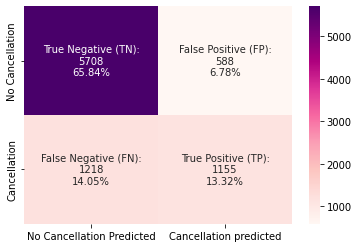

False Positive Rate (FPR): 0.093
Recall: 0.487
Precision: 0.663
F1 Score: 0.561
Accuracy: 0.792


In [ ]:
#@title
from sklearn.metrics import confusion_matrix

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", logfit)])
       # ("model", LogisticRegression(random_state=42, penalty = "none"))])

log_pipe.fit(X_train, y_train)

predictions = log_pipe.predict(X_test)

# get the confusion matrix as a numpy array
#confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat = confusion_matrix(y_true = y_test, y_pred=predictions, normalize ='all')

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision, F1 Score and Accuracy
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = f1_score(y_true=y_test, y_pred=predictions)
#Accuracy
Accuracy = (TN+TP)/(TN+TP+FN+FP)

plot_conf_matrices(y_test, predictions)
print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)
print('Accuracy: '+ '%.3f' % Accuracy)

The confusion matrix shows how the error splits in the differerent types:
*  $\text{TN}$ - correct prediction of no cancelation
*  $\text{FP}$ - model predicts cancelation but booking is not canceled
*  $\text{FN}$ - model predicts no cancelation but booking is canceled
*  $\text{TP}$ - correct prediction of cancelation

From the confusion matrix we can see that if the model makes mistakes it's around twice as likely that it will predict no cancelation but the booking will actually be canceled. This is, as already mentioned above, what we want to avoid. Looking at additional quantites, gives us even more insight on the performance of our model (*MLP workshop 7*). 

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP}+ \text{FN}}
$$

$$
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$

$$
F1 = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right)
$$
The false positive rate ($\text{FPR}$) tells us that it's unlikely ($9\%$) that the model predicts no cancelation, even if the booking in canceled. $\text{Recall}$ shows that it is likely ($49\%$) that the model will predict a cancelation without the booking being canceled. The precision gives a measurement of how many predicted cancelations were actual cancelations, a precision of $66\%$ is reasonable for our case, as this would lead to overbooking and this is less of a problem than "under"booking. The $F1$-value takes an uneven class distribution into account, $56\%$ is at this point just a number which we will compare to the $F1$ value of our final model. All these measurements give us a clearer understanding where our model needs improvement, e.g. we want $\text{Recall}$ to increase as we want to minimise $\text{FN}$.


###**Grid Search**

In [ ]:
#@title
# Example for n_splits = 5 below
# This is about just observing why StratifiedKFold is more suitable and we will use that function below 
# in the RandomizedSearchCV() function
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts(), columns=["Fold "+str(j)])
        if j == 0:
            fold_nos = fold_no
        else:
            fold_nos = pd.concat([fold_nos,fold_no], axis=1)
    print(fold_names[i])    
    print(fold_nos)

KFold
   Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0   11292   11349   11336   11378   11302
1    4311    4254    4267    4225    4300
StratifiedKFold
   Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0   11332   11332   11331   11331   11331
1    4271    4271    4272    4272    4271


Before looking into improving the model, we wanted to check whereas to use KFold or StratifiedKFold. Both methods split the training data in (in our case) 5 folds. This is useful to minimise the workload in the gridsearch algorithm used in the following section. Rather than running the model for the whole dataset for different parameters and validate it, we use 4 folds to train the data and validate it on the last remaining fold. This is done for every possible comibnation, such that each fold is the validation set once. This process is also called cross validation (*source https://scikit-learn.org/stable/modules/cross_validation.html*).

When we compare the two folding methods, we can see that for the stratified folding the numbers in each category as well as the ratios remain constant for the different folds, while for the standard folding, the acutal numbers change as well as the ratios. As we want to make sure that the ratio is constant when we model the data, we will use the stratified folding method in the following.



The model we base our improvments on is logistic regression, but on a standardised dataset. We also decided to use ``saga`` as solver as this is more suitable for larger datasets (*source https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html*). We can influence the models performance by a regularsation parameter $C$, we used the sklearn inbuild function ``RandomizedSearchCV`` to find the best $C$. Therefore, we sample $C$ from a log-uniform distribution between $0.03125$ and $32768$ and build models using cross validation. To evaluate the performance of the different models using different $C$ values, we calculate accuracy, recall, precision and F1. This will be done for every fold and will also calculate the mean and the standard deviation of these values. By ``refit``, we can define a measurement (in this case accuracy) on which the model will be refitted using the whole dataset using the best value for the given measurement
(*source https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html*).

In [ ]:
#@title
from scipy.stats.distributions import uniform, loguniform

c= 0.1

log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c,fit_intercept=True, random_state=42, solver = "saga"))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs.fit(X_train, y_train)

In [ ]:
#@title
#summary of the models 

log_rs_df = pd.DataFrame(log_rs.cv_results_)
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C",
                                                           "mean_test_accuracy", 
                                                           "mean_test_recall",
                                                           "mean_test_precision",
                                                           "mean_test_f1"]].head()


,param_model__C,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
0,5.620905,0.797600,0.488224,0.682116,0.569077
1,16547.046693,0.797588,0.488224,0.682071,0.569062
2,797.797524,0.797588,0.488224,0.682071,0.569062
3,125.641537,0.797588,0.488224,0.682071,0.569062
7,5125.66301,0.797588,0.488224,0.682071,0.569062


In the table above, we see the results of the grid search alogorithm, where it searched a range of $C$ values. We can see that the mean accuracy stays constant at  $\sim 79\%$, and we also see that recall and F1 also didn't change significantly, being still around $49\%$ and $57\%$ respectively. 

Another parameter we can adjust is the class weight in the model, this is to handle the imbalance of the dataset (having less cancelations than no cancelations).Thus, in the next gird search, we look again at different $C$ values but also add no weighting and balanced weighting as parameters. As our property of interest is recall rather than the accuray, we also set the refit parameter to recall.

In [ ]:
#@title
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c,
                                         random_state=42,
                                         solver = "saga",
                                         max_iter = 150))])
    
# specify parameters and distributions to sample from
log_param_dist = {
    'model__C':loguniform(C_list[0], C_list[-1]),
    'model__class_weight': [None, "balanced"]
}

bal_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

bal_log_rs.fit(X_train, y_train)

In [ ]:
#@title
bal_log_rs_df = pd.DataFrame(bal_log_rs.cv_results_)
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_accuracy", "mean_test_recall", 
                                                                   "mean_test_precision", "mean_test_f1"]]

,param_model__class_weight,param_model__C,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,balanced,0.397409,0.749801,0.794026,0.528664,0.634723
5,balanced,3.191362,0.749763,0.794026,0.528614,0.634688
6,balanced,572.626869,0.749763,0.794026,0.528614,0.634688
8,balanced,3211.102086,0.749763,0.794026,0.528614,0.634688
4,balanced,0.069911,0.749801,0.793979,0.528665,0.634709
7,balanced,0.06831,0.749801,0.793979,0.528665,0.634709
9,balanced,0.031589,0.749840,0.793838,0.528720,0.634704
0,None,5.620905,0.797703,0.488646,0.682259,0.569414
2,None,125.641537,0.797703,0.488646,0.682259,0.569414
3,None,15.101867,0.797703,0.488646,0.682259,0.569414


This table summarised the results of the grid search algorithm which included different $C$ values as well as weighting. We can see that if the class weight is balanced, we get a big improvement for the mean recall, from $\sim 42\%$ to $\sim 79\%$. The $F1$ value also increased to $63\%$, which is an improvement and shows that we deal better with the fact that the data is unbalanced. The mean accuracy is slightly worse than before, but we accept that as we are more interested in a higher value of recall. The next section will present our final model and discuss why we have chosen it.

## **4. Discussion & Conclusions**


The perfomance and reliability of our final model will be explored in this section. This will be compared to the previous model to highlight any improvements that were made for the predicitive model for cancelations of bookings. We will then provide an overview of which features were found to be important for cancelations and which were less likely to influence cancelation.

###**Model Prediction**


for C =  0.031589


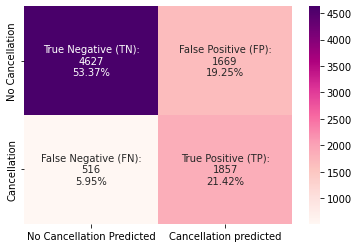

False Positive Rate (FPR): 0.265
Recall: 0.783
Precision: 0.527
F1 Score: 0.630
Accuracy: 0.748


In [ ]:
#@title
# 0.031589 is the best recall we can find I think and accuracy combined and happens when we use weights that balance the ratios of 0s and 1s in y
# Note instead of balanced we could try oversampling or undersampling as discussed in workshop 7.
# [MLP Workshop 7]
c = 0.031589
print("")
print("for C = ", c)

log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c,random_state=42, solver = "saga",class_weight = "balanced"))])

log_pipe.fit(X_train, y_train)

# use the classifier to predict the validation set    
# predictions = log_pipe.predict(X_val)
predictions = log_pipe.predict(X_test)

# get the confusion matrix as a numpy array
# confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat = confusion_matrix(y_true = y_test, y_pred=predictions)

FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

# Calculation of FPR, Recall, Precision, F1 Score and Accuracy
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = f1_score(y_true=y_test, y_pred=predictions)
# Accuracy
Accuracy = (TN+TP)/(TN+TP+FN+FP)

plot_conf_matrices(y_test, predictions)
print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)
print('Accuracy: '+ '%.3f' % Accuracy)

Our final model is a logistic regression model, using balanced classes in order to account for the ratio of the response variable. The plot above shows the confusion matrix which is used to evaluate the performance of the classification. The $\text{FN}$ value shows when the model predicts no cancelation and there is a cancelation. The $\text{FN}$ value of $516$ in our final model is reduced from the previous calculated value in section 3. This leads to an improvement in the recall value. In the context of bookings the FN value is more important than $\text{FP}$ as bookings which are predicted not to be canceled which end up being canceled is worse for hotel profitability than when a cancelation is predicted and there isn't a cancelation. The recall value in our final model is $0.783$. This shows that the ratio of bookings that were correctly predicted to be canceled were relatively well predicted. This would allow the hotel to confidently predict cancelations and would allow for the readvertisement of hotel rooms for bookings that are predicted to be canceled. Thus, ensuring that hotel bookings can reach a full capacity and increased profitability.

The precision measure shows the proportion of bookings that were correctly predicted as canceled to the total bookings predicted to be canceled. Here the ratio is $0.527$, meaning that about half of the bookings predicted to be canceled were indeed canceled. This may not sound very promising but precision comes second in our case, since we have high recall. We predicted most of the bookings that were indeed canceled correctly and the predictions of no cancelations that were canceled, are few. This minimises the probability of under-booking which reduces the loss made for hotels. The relation between recall and precision can be seen in the plot below. 


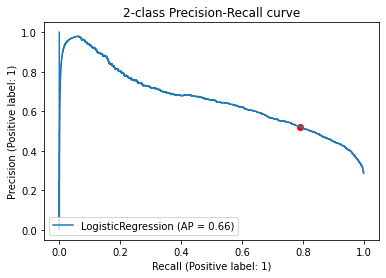

In [ ]:
#@title
#precision_recall_curve(y_val, predictions)
from sklearn.metrics import PrecisionRecallDisplay

c = 0.031589
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c,random_state=42, solver = "saga",class_weight = "balanced"))])

log_pipe.fit(X_train, y_train)
display = PrecisionRecallDisplay.from_estimator(log_pipe, X_test, y_test, name="LogisticRegression")
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.scatter(x = 0.79, y = 0.52, c = 'red')

This plot shows how recall and precision relate to each other for the given dataset. We can see that a higher recall leads to a smaller precision. We also marked the recall and precision of our final model, where we were mainly interested in increasing the recall value. We can see from this plot, that by achieving a relatively high recall value, the precision nearly decreases by $50\%$. This means that now, there is a greater chance that the prediction for a cancelation is incorrect.

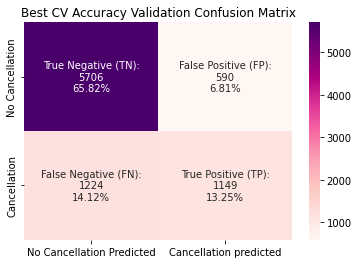

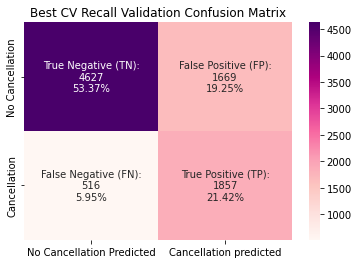

In [ ]:
#@title
# best accuracy model
log_pipe_acc = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = 5.620905,random_state=42, solver = "saga"))])

log_pipe_acc.fit(X_train, y_train)

# best recall model
log_pipe_recall = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = 0.031589,random_state=42, solver = "saga",class_weight = "balanced"))])

log_pipe_recall.fit(X_train, y_train)

plot_conf_matrices(y_test, log_pipe_acc.predict(X_test), "Best CV Accuracy Validation Confusion Matrix")

plot_conf_matrices(y_test, log_pipe_recall.predict(X_test), "Best CV Recall Validation Confusion Matrix")




As mentioned previously, we believed that the value of FN is the most important when ensuring that the hotel doesn't make a loss. In order to attain the improvement in FN, there was a cost to accuracy and the value of FP as you can see in these 2 confusion matrices contrasting each other. To be able to predict more accurately the bookings that will not be canceled, we would have to limit our ability to correctly predict those that will cancel.

### **Feature Influence**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

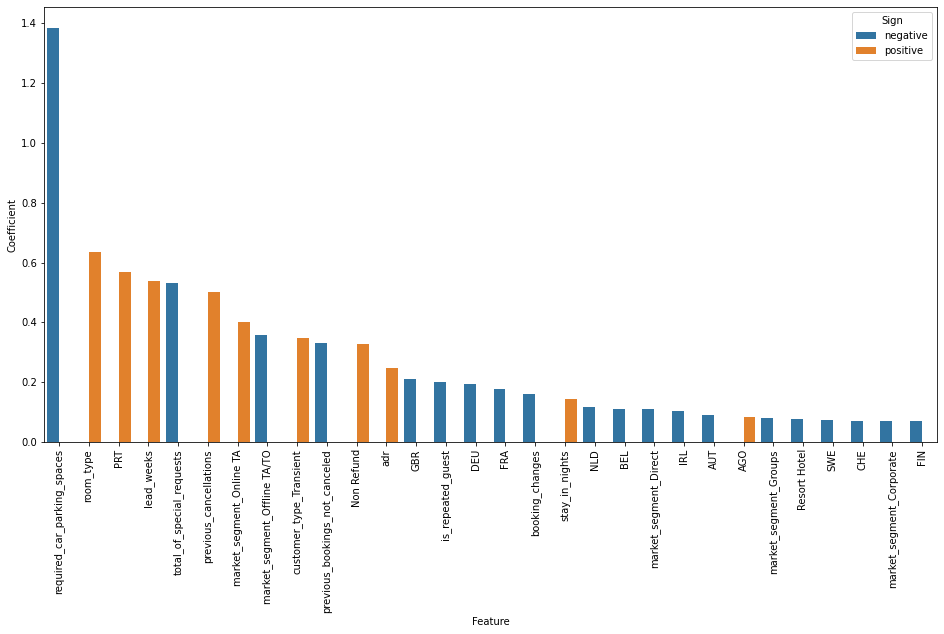

In [ ]:
#@title
# Graph of 30 greatest coefficients, colours indicates if it is negative or positive

coefs = log_pipe['model'].coef_.flatten()
features = data_x.columns
signs = np.where(coefs > 0,"positive","negative")
coeflist = pd.DataFrame(columns = ["Feature","Coefficient","Sign"])
coeflist["Feature"] = features
coeflist["Coefficient"] = np.abs(coefs)
coeflist["Sign"] = signs
coeflist_upd = coeflist.sort_values("Coefficient", axis = 0, ascending = False)
head_coefs = coeflist_upd.head(30) #change if we want more 

plt.figure(figsize = (16,8))
sns.barplot(x = "Feature",y = "Coefficient",data = head_coefs, hue = "Sign")
plt.xticks(rotation = 90)

The plot shows the influence of the features on a booking being either canceled or not canceled. The graph specifically looks at the 30 most influential coefficients and whether they are affecting bookings being canceled positively or negatively. The blue bar plots show features less likely to lead to a booking being canceled, whilst the orange bar plots show features that are more likely to lead to a booking being canceled.

The top 3 features less likely to lead a cancelation: 
- `required_car_parking_spaces`
- `total_of_special_requests`
- `market_segment_Offline TA/TO`

A customer that opted for a car parking space was more likely not to cancel on their booking, whilst asking for a lot of special requests will also make it less likely to cancel a booking. The market segment feature accounts for bookings that were made offline through a travel agent or tour operator. This feature also led to less likely cancelations.

The top 3 features more likely to lead to a cancelation: 
- `room_type`
- `PRT`
- `lead_weeks`

The room type, meaning that the assigned room is the room that is reserved, customer bookings from Portugal and the amount of weeks between the time the booking was made to the date of arrival were more likely to lead to a cancelation. 

Using the analysis of the way in which features interact with cancelations, it can be used to understand why individuals may decide to cancel and how this can be accounted for. There could be numerous avenues in which hotels could take advantage of the information. If a booking contained certain features that were more likely to lead to a cancelation, i.e., `adr` (average daily rate) and `stay_in_nights` (how many nights stayed), then the hotel could offer a reduced car parking fee as this is a high influence feature that leads to less likely chance of cancelation. This is one example by which the influence and impact of features can be analysed in order to promote less hotel booking cancelations.

### **Final Thoughts**

In conclusion, we find that the model we built is able to predict whether a booking will be canceled or not. Our focus was to minimise the incorreclty predicted cancelations as this would have the worst outcome for hotel bookings. The model is based on logistic regression and has high metrics realting to accuracy and recall values. Our model may lead to overbooking, which we believe to be more feasible than having empty rooms for the future sustainability of the two hotels.